In [ ]:
# default_exp fitting

# Comparing InstanceCMR and PrototypeCMR Using the Murdock (1970) Dataset
Here we'll demonstrate the equivalent performance of the Classic CMR and InstanceCMR models on the dataset from Murdock (1970) and the likelihood-based fitting technique outlined elsewhere in this project.

In [ ]:
from compmemlearn.fitting import cmr_murd_objective_function, apply_and_concatenate
from compmemlearn.models import Classic_CMR, Instance_CMR
from compmemlearn.datasets import prepare_murdock1970_data

murd_trials0, murd_events0, murd_length0 = prepare_murdock1970_data('../../data/mo1970.txt')

murd_events0.head()

,subject,list,item,input,output,study,recall,repeat,intrusion
0,1,1,1,1,NaN,True,False,0,False
1,1,1,2,2,NaN,True,False,0,False
2,1,1,3,3,NaN,True,False,0,False
3,1,1,4,4,NaN,True,False,0,False
4,1,1,5,5,NaN,True,False,0,False


## Classic CMR Fitting

In [ ]:
from scipy.optimize import differential_evolution
from numba.typed import List
import numpy as np

free_parameters = [
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity',]

lb = np.finfo(float).eps
ub = 1-np.finfo(float).eps

bounds = [
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10)
]


# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model
cost_function = cmr_murd_objective_function(
    List([murd_trials0]), 
    {'item_counts': List([murd_length0]), 'sampling_rule': 0, 'familiarity_scale': 0}, free_parameters)

cmr_result = differential_evolution(cost_function, bounds, disp=False)
print(cmr_result)


     fun: 22973.323130612865
     jac: array([  0.28121576,   3.11592885,   1.78588379,   0.45292836,
         1.5104888 ,  -1.15178409,   0.28703653,   0.        ,
       -16.80054993,  -4.52128006,   0.05311449])
 message: 'Optimization terminated successfully.'
    nfev: 7704
     nit: 43
 success: True
       x: array([6.82000657e-01, 8.64850396e-02, 8.25154187e-01, 5.05794484e-01,
       9.61786838e-02, 2.95094989e-01, 3.32799367e+00, 5.73210744e+01,
       3.13864585e-02, 3.36733414e-01, 7.35994415e+00])


Now we compute the SPC, CRP, and PFR stats associated with these model fits, contrasted against the actual data.

In [ ]:
from compmemlearn.datasets import simulate_data
import pandas as pd
from psifr import fr

model = Classic_CMR(
    **{**{'item_count': murd_length0, 'presentation_count': murd_length0, 'sampling_rule': 0}, 
               **{free_parameters[i]:cmr_result.x[i] for i in range(len(cmr_result.x))}})

sim_df = simulate_data(model, 1000)
true_df = murd_events0.copy()

cmr_spc = apply_and_concatenate(fr.spc, sim_df, true_df, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_lag_crp = apply_and_concatenate(fr.lag_crp, sim_df, true_df, 'source', ['PrototypeCMR', 'data'])
cmr_pfr = apply_and_concatenate(fr.pnr, sim_df, true_df, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_pfr = cmr_pfr.query('output <= 1')

We'll eventually want our Classic CMR and Instance CMR fits compared in one figure, but for the moment let's peek at our CMR results:

I'm going to want to draw a clearer differentiation between the model fit and the data line but this at least gives us an indication that the model fitting is mostly working.

## Instance CMR Fitting

We need a unique fitting function for `Instance_CMR` that uses that model.

In [ ]:
# export

import numpy as np
from numba import njit
from compmemlearn.models import Instance_CMR

@njit(fastmath=True, nogil=True)
def icmr_murd_likelihood(data_to_fit, item_counts, encoding_drift_rate, 
                    start_drift_rate, recall_drift_rate, shared_support, 
                    item_support, learning_rate, primacy_scale, primacy_decay, 
                    stop_probability_scale, stop_probability_growth, 
                    choice_sensitivity, context_sensitivity, feature_sensitivity):
    """
    Generalized cost function for fitting the InstanceCMR model optimized 
    using the numba library.
    
    Output scales inversely with the likelihood that the model and specified 
    parameters would generate the specified trials. For model fitting, is 
    usually wrapped in another function that fixes and frees parameters for 
    optimization.

    **Arguments**:
    - data_to_fit: typed list of int64-arrays where rows identify a unique 
        trial of responses and columns corresponds to a unique recall index.  
    - A configuration for each parameter of `Instance_CMR`.

    **Returns** the negative sum of log-likelihoods across specified trials 
    conditional on the specified parameters and the mechanisms of InstanceCMR.
    """
        
    result = 0.0
    for i in range(len(item_counts)):
        item_count = item_counts[i]
        trials = data_to_fit[i]
        
        model = Instance_CMR(item_count, item_count, encoding_drift_rate, 
                          start_drift_rate, recall_drift_rate, shared_support, 
                          item_support, learning_rate, primacy_scale, 
                          primacy_decay, stop_probability_scale, 
                          stop_probability_growth, choice_sensitivity,
                           context_sensitivity, feature_sensitivity)

        model.experience(np.eye(item_count, item_count + 1, 1))

        likelihood = np.ones((len(trials), item_count))

        for trial_index in range(len(trials)):
            trial = trials[trial_index]

            model.force_recall()
            for recall_index in range(len(trial) + 1):

                # identify index of item recalled; if zero then recall is over
                if recall_index == len(trial) and len(trial) < item_count:
                    recall = 0
                else:
                    recall = trial[recall_index]

                # store probability of and simulate recalling item w this index
                activation_cue = np.hstack(
                    (np.zeros(model.item_count + 1), model.context))
                likelihood[trial_index, recall_index] = \
                    model.outcome_probabilities(activation_cue)[recall]

                if recall == 0:
                    break
                model.force_recall(recall)

            # reset model to its pre-retrieval (but post-encoding) state
            model.force_recall(0)
        result -= np.sum(np.log(likelihood))
        
    return result

In [ ]:
# export

def icmr_murd_objective_function(data_to_fit, fixed_parameters, free_parameters):
    """
    Generates and returns an objective function for input to support search 
    through parameter space for ICMR model fit using an optimization function.

    Arguments:  
    - fixed_parameters: dictionary mapping parameter names to values they'll 
        be fixed to during search, overloaded by free_parameters if overlap  
    - free_parameters: list of strings naming parameters for fit during search  
    - data_to_fit: array where rows identify a unique trial of responses and 
        columns corresponds to a unique recall index

    Returns a function that accepts a vector x specifying arbitrary values for 
    free parameters and returns evaluation of icmr_likelihood using the model 
    class, all parameters, and provided data.
    """
    
    return lambda x: icmr_murd_likelihood(data_to_fit, **{**fixed_parameters, **{
        free_parameters[i]:x[i] for i in range(len(x))}})

In [ ]:
free_parameters = [
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
#    'choice_sensitivity',
    'context_sensitivity',
#    'feature_sensitivity'
]

lb = np.finfo(float).eps
ub = 1-np.finfo(float).eps

bounds = [
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10),
#    (lb, 10),
#    (lb, 10)
]

# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model
cost_function = icmr_murd_objective_function(
    List([murd_trials0]), 
    {'item_counts': List([murd_length0]), 'choice_sensitivity': 1, 'feature_sensitivity': 1}, free_parameters)

icmr_result = differential_evolution(cost_function, bounds, disp=True)

differential_evolution step 1: f(x)= 40860.5
differential_evolution step 2: f(x)= 29871.6
differential_evolution step 3: f(x)= 28199.6
differential_evolution step 4: f(x)= 28199.6
differential_evolution step 5: f(x)= 27771.9
differential_evolution step 6: f(x)= 27708
differential_evolution step 7: f(x)= 27662.2
differential_evolution step 8: f(x)= 27604.7
differential_evolution step 9: f(x)= 26873.3
differential_evolution step 10: f(x)= 26873.3
differential_evolution step 11: f(x)= 26873.3
differential_evolution step 12: f(x)= 26873.3
differential_evolution step 13: f(x)= 26873.3
differential_evolution step 14: f(x)= 26873.3
differential_evolution step 15: f(x)= 26873.3
differential_evolution step 16: f(x)= 26873.3
differential_evolution step 17: f(x)= 26873.3
differential_evolution step 18: f(x)= 26873.3
differential_evolution step 19: f(x)= 26726.3
differential_evolution step 20: f(x)= 26726.3
differential_evolution step 21: f(x)= 26726.3
differential_evolution step 22: f(x)= 26032.1

In [ ]:
icmr_result

     fun: 22858.259064454294
     jac: array([ 5.91128261e+02,  6.71551243e+02, -6.07781109e+02,  6.49487016e+05,
       -9.06252681e+03,  5.34268038e+03,  9.28230298e+00,  0.00000000e+00,
       -1.08355962e+03, -3.46103116e+02,  1.30094487e+02])
 message: 'Optimization terminated successfully.'
    nfev: 17352
     nit: 87
 success: True
       x: array([8.01254413e-01, 2.22044605e-16, 9.11469078e-01, 5.39479791e-07,
       3.03861559e-04, 3.54601271e-04, 6.27231369e+00, 1.81423496e+01,
       3.17133160e-02, 3.34395632e-01, 1.16757494e+00])

In [ ]:
model = Instance_CMR(
    **{**{'item_count': murd_length0, 'presentation_count': murd_length0, 'choice_sensitivity': 1, 'feature_sensitivity': 1}, 
    **{free_parameters[i]:icmr_result.x[i] for i in range(len(icmr_result.x))}})

sim_df = simulate_data(model, 1000)
icmr_spc = apply_and_concatenate(fr.spc, sim_df, true_df, contrast_name='source', labels=['InstanceCMR', 'data'])
icmr_lag_crp = apply_and_concatenate(fr.lag_crp, sim_df, true_df, 'source', ['InstanceCMR', 'data'])
icmr_pfr = apply_and_concatenate(fr.pnr, sim_df, true_df, contrast_name='source', labels=['InstanceCMR', 'data'])
icmr_pfr = icmr_pfr.query('output <= 1')

icmr_pfr.head()

,source,subject,output,input,prob,actual,possible
0,InstanceCMR,0,1,1,0.0,0,1
1,InstanceCMR,0,1,2,0.0,0,1
2,InstanceCMR,0,1,3,0.0,0,1
3,InstanceCMR,0,1,4,0.0,0,1
4,InstanceCMR,0,1,5,0.0,0,1


## Comparing Fitted Benchmark Phenomena

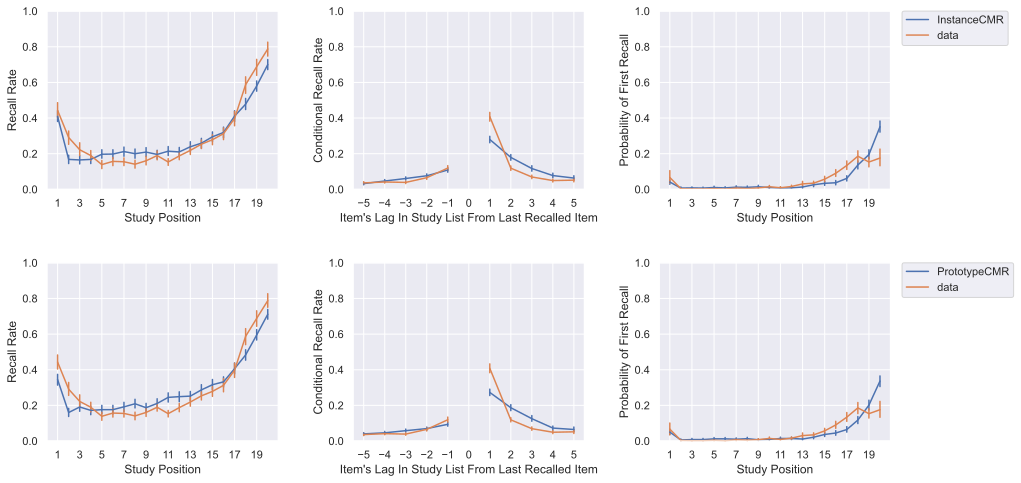

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

%config InlineBackend.figure_formats = ['svg']
sns.set(style='darkgrid')

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 15/2), sharey=False)

# serial position curve
sns.lineplot(ax=axes[0, 0], data=icmr_spc, x='input', y='recall', err_style='bars', hue='source', legend=False)
axes[0, 0].set(xlabel='Study Position', ylabel='Recall Rate')
axes[0, 0].set_xticks(np.arange(1, 21, 2))
axes[0, 0].set_ylim((0, 1))

sns.lineplot(ax=axes[1, 0], data=cmr_spc, x='input', y='recall', err_style='bars', hue='source', legend=False)
axes[1, 0].set(xlabel='Study Position', ylabel='Recall Rate')
axes[1, 0].set_xticks(np.arange(1, 21, 2))
axes[1, 0].set_ylim((0, 1))

# lag crp curve
max_lag = 5
filt_neg = f'{-max_lag} <= lag < 0'
filt_pos = f'0 < lag <= {max_lag}'

sns.lineplot(ax=axes[0, 1], data=icmr_lag_crp.query(filt_neg), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
sns.lineplot(ax=axes[0, 1], data=icmr_lag_crp.query(filt_pos), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
axes[0, 1].set(xlabel='Item\'s Lag In Study List From Last Recalled Item', ylabel='Conditional Recall Rate')
axes[0, 1].set_xticks(np.arange(-5, 6, 1))
axes[0, 1].set_ylim((0, 1))

sns.lineplot(ax=axes[1, 1], data=cmr_lag_crp.query(filt_neg), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
sns.lineplot(ax=axes[1, 1], data=cmr_lag_crp.query(filt_pos), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
axes[1, 1].set(xlabel='Item\'s Lag In Study List From Last Recalled Item', ylabel='Conditional Recall Rate')
axes[1, 1].set_xticks(np.arange(-5, 6, 1))
axes[1, 1].set_ylim((0, 1))

# pfr
sns.lineplot(data=icmr_pfr, x='input', y='prob', err_style='bars', ax=axes[0, 2], hue='source')
axes[0, 2].set(xlabel='Study Position', ylabel='Probability of First Recall')
axes[0, 2].set_xticks(np.arange(1, 21, 2))
axes[0, 2].set_ylim((0, 1))

sns.lineplot(data=cmr_pfr, x='input', y='prob', err_style='bars', ax=axes[1, 2], hue='source')
axes[1, 2].set(xlabel='Study Position', ylabel='Probability of First Recall')
axes[1, 2].set_xticks(np.arange(1, 21, 2))
axes[1, 2].set_ylim((0, 1))

# set legend of axis 2 outside the plot, to the right
axes[0, 2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes[1, 2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.tight_layout(pad=3)
plt.savefig('overall_murdock1970.pdf', bbox_inches='tight')

## Individual-Level Model Fitting

In [ ]:
free_parameters = [
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity',]

lb = np.finfo(float).eps
ub = 1-np.finfo(float).eps

bounds = [
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10)
]

subject_trial_count = 20 # Each subject gets 20 trials/lists a piece.
cmr_results = []

for subject, start_index in enumerate(range(0, len(murd_trials0), subject_trial_count)):
    print(subject, start_index)

    # cost function to be minimized
    # ours scales inversely with the probability that the data could have been 
    # generated using the specified parameters and our model
    cost_function = cmr_murd_objective_function(
        List([murd_trials0[start_index:start_index+subject_trial_count]]), 
        {'item_counts': List([murd_length0]), 'sampling_rule': 0, 'familiarity_scale': 0}, free_parameters)

    cmr_results.append(differential_evolution(cost_function, bounds, disp=False))
    print(cmr_results[-1].fun)

0 0
297.26212708234004
1 20
244.21733682347966
2 40
339.02955504623213
3 60
339.16455741913984
4 80
347.0790762274163
5 100
307.4928691753374
6 120
262.5008995986158
7 140
288.8342450112993
8 160
232.94746345939018
9 180
358.8416017372063
10 200
184.76488338391638
11 220
317.52265049847654
12 240
380.0135053965807
13 260
270.0554286328132
14 280
290.1895181761838
15 300
335.2504705838646
16 320
312.1120960992759
17 340
289.4740539677995
18 360
395.2732843957503
19 380
394.62176968227374
20 400
313.0112256791989
21 420
337.0956822605317
22 440
386.92739214566484
23 460
297.72218719628034
24 480
273.4198313987699
25 500
371.96458419576584
26 520
327.45204658823724
27 540
292.04687469740026
28 560
348.41926997869206
29 580
300.37458240766034
30 600
347.5912024703275
31 620
310.1791619433251
32 640
336.62921329992287
33 660
388.91716122422184
34 680
314.878711878232
35 700
387.30626519285596
36 720
299.11211749804846
37 740
298.5316840856595
38 760
238.0241423074332
39 780
233.307645984718

In [ ]:
free_parameters = [
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
#    'choice_sensitivity',
    'context_sensitivity',
#    'feature_sensitivity'
]

lb = np.finfo(float).eps
ub = 1-np.finfo(float).eps

bounds = [
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10),
#    (lb, 10),
#    (lb, 10)
]

subject_trial_count = 20 # Each subject gets 20 trials/lists a piece.
icmr_results = []

for subject, start_index in enumerate(range(0, len(murd_trials0), subject_trial_count)):
    print(subject, start_index)

    # cost function to be minimized
    # ours scales inversely with the probability that the data could have been 
    # generated using the specified parameters and our model
    cost_function = icmr_murd_objective_function(
    List([murd_trials0[start_index:start_index+subject_trial_count]]), 
    {'item_counts': List([murd_length0]), 'choice_sensitivity': 1, 'feature_sensitivity': 1}, free_parameters)

    icmr_results.append(differential_evolution(cost_function, bounds, disp=False))
    print(icmr_results[-1].fun)

0 0
302.4076817312373
1 20
238.12520597087536
2 40
331.06189304243395
3 60
336.5285822179696
4 80
348.7198859785966
5 100
403.63585462481603
6 120
258.6615487229952
7 140
287.38287729611363
8 160
231.74553031850553
9 180
352.7961727308689
10 200
186.78852241691132
11 220
313.8929599098086
12 240
387.36264300475716
13 260
264.92329527723757
14 280
290.70334783299904
15 300
335.07613156878597
16 320
312.0276085187096
17 340
287.3511562574955
18 360
394.98218475650623
19 380
388.5900318246346
20 400
312.3190365962388
21 420
337.2072863384368
22 440
420.9313504274625
23 460
298.40703142510625
24 480
279.44361245266686
25 500
367.9015101988792
26 520
326.0721677506247
27 540
299.2580622133998
28 560
349.50055794152223
29 580
302.22606955060456
30 600
340.484367496217
31 620
314.2631605142468
32 640
331.5114520281059
33 660
387.0129503016721
34 680
312.75557089849696
35 700
388.8625667982341
36 720
300.88598837205654
37 740
297.80902627947233
38 760
239.48963480253778
39 780
235.709076558629

### Visualization
We'll build a dataframe containing the log-likelihood scores corresponding to each fitted parameter configuration across subjects, factored by model type. Then we'll visualize the difference in score distribution.

In [ ]:
individual_fits = [result.fun for result in cmr_results] + [result.fun for result in icmr_results]
labels = ['PrototypeCMR'] * len(cmr_results) + ['InstanceCMR'] * len(icmr_results)
individual_df = pd.DataFrame(individual_fits, index=labels, columns=['Fit']).reset_index()
individual_df.columns = ['Model', 'Fit']

In [ ]:
print(pd.DataFrame(group.describe().rename(columns={'Fit':name}).squeeze()
            for name, group in individual_df.groupby('Model')).T.to_markdown())

|       |   InstanceCMR |   PrototypeCMR |
|:------|--------------:|---------------:|
| count |       72      |         72     |
| mean  |      301.507  |        298.94  |
| std   |       55.7279 |         54.168 |
| min   |      158.871  |        154.257 |
| 25%   |      263.358  |        260.714 |
| 50%   |      302.317  |        299.33  |
| 75%   |      336.698  |        336.746 |
| max   |      420.931  |        395.273 |


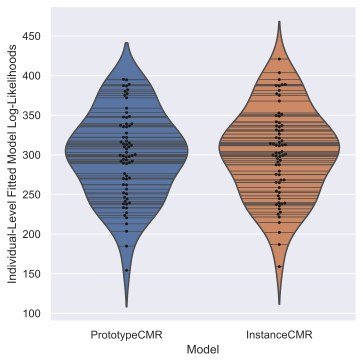

In [ ]:
sns.set(style="darkgrid")

g = sns.catplot(x='Model', y='Fit', data=individual_df, kind='violin', inner='stick')
sns.swarmplot(x="Model", y="Fit", color="k", size=3, data=individual_df, ax=g.ax)
g.ax.set_ylabel('Individual-Level Fitted Model Log-Likelihoods');
plt.savefig('individual_murdock1970.pdf', bbox_inches="tight")